# Classification

## Getting data

In [1]:
# Import libraries

import scipy
import numpy
import sklearn
import pandas as pds
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import tree
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import cross_validate 
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.cluster import DBSCAN

On utilise les mêmes données issues comme dans le notebook *clustering*. On les traite de même façon, on enlève les **NA** et les colonnes ayant une corrélation non-désirée. Enfin, on se retrouve avec 6 colonnes représentant  CO<sub>2 </sub> emissions, l'accès à l'éléctricité, la croissance de PIB, l'exporte, le taux de mortalité et le pourcentage de surface boisée.

In [2]:
dt = pds.read_csv('569a01d3-3538-49da-a03a-63d8d3151235_Data.txt', sep="\t") # load a pandas dataframe from csv in current directory
dt = dt[:-5]
stamps = ['Time\t', 'Time Code\t', 'Country Name\t', 'Country Code\t', 'CO2 emissions (kg per 2011 PPP $ of GDP)\t', \
          'Access to electricity (% of population)\t', 'Electricity production from oil, gas and coal sources (% of total)\t', \
          'GDP per capita growth (annual %)\t', 'Industry (including construction), value added per worker (constant 2010 US$)\t', \
          'Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)\t', \
          'International tourism, receipts (% of total exports)\t', 'Exports of goods and services (% of GDP)\t', \
          'Imports of goods and services (% of GDP)\t', 'Urban population (% of total population)\t', \
          'Population, total\t', 'Death rate, crude (per 1,000 people)\t', 'Forest area (% of land area)\t']
dt.columns = stamps
dt.index = dt['Country Name\t']
dt = dt.drop(['Time\t', 'Time Code\t', 'Country Name\t', 'Country Code\t'], axis=1)
dt = dt.dropna()
dt = dt.drop(['Imports of goods and services (% of GDP)\t', 'Population, total\t', 'Urban population (% of total population)\t', \
              'Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)\t', \
              'International tourism, receipts (% of total exports)\t', \
              'Industry (including construction), value added per worker (constant 2010 US$)\t', \
              'Electricity production from oil, gas and coal sources (% of total)\t'], axis=1)

On regarde la table de corrélation entre les variables. On voit que la croissance de PIB est une variable bien corrélée avec les autres, en même temps elle reste une grandeur économique bien intérpretable. On s'intéressera à elle lors de nos études.

Text(0.5,0.98,'Correlation matrix')

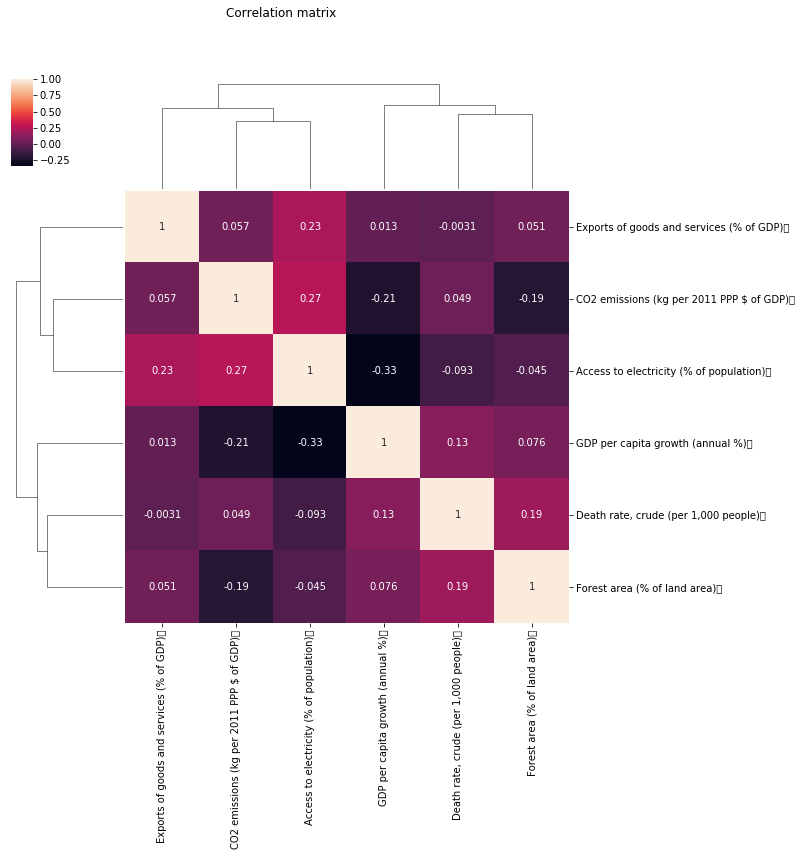

In [3]:
g = sns.clustermap(dt.corr(),annot=True) 
g.fig.suptitle('Correlation matrix') 

## Labeling

On choisit la colonne *croissance de PIB* comme le label qu'on étudiera. On crée $n$ classes de cette colonne grâce à la discrétisation d'après les valeurs croissantes (on divise le set en $n$ morceaux de même effectif). Ensuite on procedéra en enlevant cette colonne de nos données, tout en gardant la trace de cette colonne pour pouvoir comparer les résultats. 

Pour commencer, on construira notre modèle autour du cas le plus simple, c-à-d $n=2$. On va donc séparer notre variable *taux de croissance de PIB* en deux parties : celles ayant une valeur plus grande que la médiane et celles ayant une valeur plus petite. 
Notre modèle évaluera alors si les pays possèdent un taux de croissance de PIB élevé ou faible (par rapport à la médiane à partir de tous les pays).

In [4]:
PIB = dt['GDP per capita growth (annual %)\t']
PIB.describe()

count    120.000000
mean       2.172657
std        2.421433
min       -4.731050
25%        1.025368
50%        2.167883
75%        3.563021
max        7.766030
Name: GDP per capita growth (annual %)\t, dtype: float64

In [5]:
labels = []
for i in range(120):
    if PIB[i] < 2.167883:
        labels.append(1)
    else:
        labels.append(2)
sum(labels) == 180

True

In [6]:
df = dt
df = df.drop('GDP per capita growth (annual %)\t', axis=1)

## Standardization

On remarque que nos données n'ont pas la même échelle ce qui pourrait nous poser problèmes surtout pour la méthode **K-NearestNeighbours**. Par conséquent, on va standardiser les données grâce à la z-score transformation.

In [7]:
df.describe()

,CO2 emissions (kg per 2011 PPP $ of GDP),Access to electricity (% of population),Exports of goods and services (% of GDP),"Death rate, crude (per 1,000 people)",Forest area (% of land area)
count,120.000000,120.000000,120.000000,120.000000,120.000000
mean,0.243865,87.342678,43.585065,7.878642,30.581768
std,0.133400,23.282504,29.581383,2.762408,20.179767
min,0.075353,13.500000,9.170091,2.337000,0.006462
25%,0.155270,87.990330,25.319687,5.982250,12.592530
50%,0.212866,99.988857,37.335440,7.366500,31.838990
75%,0.311126,100.000000,51.702944,9.533250,43.709366
max,0.724804,100.000000,212.607099,15.100000,73.111981


In [8]:
zscore = StandardScaler().fit(df)
dfz = pds.DataFrame(zscore.transform(df), index=df.index, columns=df.columns)
dfz.describe()

,CO2 emissions (kg per 2011 PPP $ of GDP),Access to electricity (% of population),Exports of goods and services (% of GDP),"Death rate, crude (per 1,000 people)",Forest area (% of land area)
count,1.200000e+02,1.200000e+02,1.200000e+02,1.200000e+02,1.200000e+02
mean,-1.517305e-16,5.958197e-16,-2.275957e-16,2.821817e-16,-6.615079e-17
std,1.004193e+00,1.004193e+00,1.004193e+00,1.004193e+00,1.004193e+00
min,-1.268508e+00,-3.184893e+00,-1.168278e+00,-2.014503e+00,-1.521499e+00
25%,-6.669179e-01,2.793374e-02,-6.200509e-01,-6.893780e-01,-8.951870e-01
50%,-2.333533e-01,5.454398e-01,-2.121547e-01,-1.861742e-01,6.256233e-02
75%,5.063156e-01,5.459204e-01,2.755759e-01,6.014847e-01,6.532603e-01
max,3.620360e+00,5.459204e-01,5.737755e+00,2.625115e+00,2.116404e+00


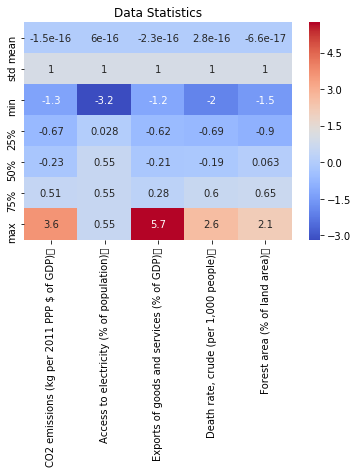

In [9]:
stats = dfz.describe()
stats = stats.drop('count',axis=0)
plt.title('Data Statistics')
sns.heatmap(stats,annot=True,cmap='coolwarm')

On voit que les variables ont des moyennes quasi-nulles et l'écart-type égal à 1. 

## Models

### First *k*-nearest neighbors model

Pour déterminer la classe appartenante à chaque pays, on construit d'abord un modèle k-NN classique. Cet algorhitme assigne la classe d'un point d'après les classes de ses *k* voisins les plus proches. On utilise la méthode *KNeighborsClassifier()* à partir de la bibliothèque *sklearn* par défaut.

On utilise nos données standardisées *dfz* ainsi que les données brutes pour comparer les résultats et mettre en évidence l'intéret de standardiser. 
On applique la cross-validation pour déterminer la précision de nos modèles. On sépare les données en 5 sub-sets différents qui servent un après l'autre comme partie validée de la base de données (pour cette partie, on a le label des données : c'est le *training* dataset). Pour les 4 autres parties, on estimera les labels. 

In [10]:
cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

scoring = ['accuracy',
           'precision_weighted',
           'recall_weighted',
           'f1_weighted']

knn = KNeighborsClassifier()
scores = cross_validate(knn, df, labels, scoring=scoring,cv=cv, return_train_score=True)
scores = pds.DataFrame(scores).mean()

knn = KNeighborsClassifier()
scores_z = cross_validate(knn, dfz, labels, scoring=scoring,cv=cv, return_train_score=True)
scores_z = pds.DataFrame(scores_z).mean()

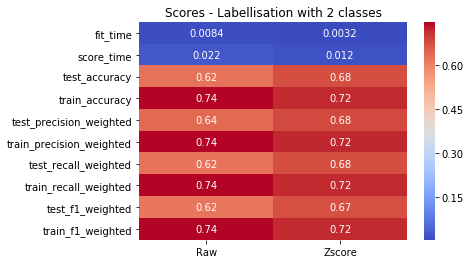

In [11]:
full_scores = pds.DataFrame({"Raw": scores, "Zscore":scores_z})
plt.title('Scores - Labellisation with 2 classes')
sns.heatmap(full_scores,annot=True,cmap='coolwarm')

On compare les scores du modèle avec les données brutes et ceux du modèle avec les données après z-score transformation. On regarde la ligne *test_accuracy* qui nous donne la meuilleure information sur la précision de modèle. En effet, un modèle correcte est un modèle qui classe bien les données de la partie test.

Pour le modèle raw, on voit que *test_accuracy = 0.62*, cependant pour le modèle z-score *test_accuracy = 0.68*. La transformation permet de classifier mieux l'appartenance aux classes. Effectivement, certaines variables comme l'accès à l'éléctricité ou les forêts ont des valeurs proches de 100 et d'autres comme le PIB sont petites. Cette incohérence introduit plus d'erreur dans le modèle et les prédictions sont alors moins justes.

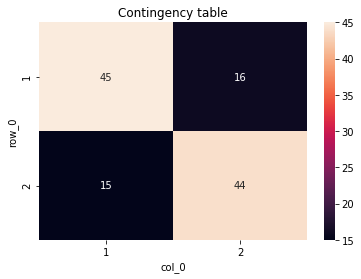

In [12]:
knn.fit(dfz, labels)
clusters = knn.predict(dfz)
crosstab = pds.crosstab(clusters,np.asarray(labels))
plt.title('Contingency table')
sns.heatmap(crosstab, annot=True)

On peut utiliser une table de contingence pour comparer les résultats du modèle à la réalité. On voit qu'un quart de chaque classe est mal identifié.

### More *k*-nearest neighbors models

Après avoir utilisé l'objet **KNeighborsClassifier** par défaut, on va désormais faire varier plusieurs paramètres de ce conteneur. Nous obtiendrons donc plusieurs modèles et pourront comparer les résultats et conserver les meilleurs.

On garde la division en 5 sub-sets et on variera le nombre de voisins (*1, 3, 5*), le poids (*uniform, distance*) et la distance (*euclidienne, manhattan*). On créera alors 12 modèles *k*-NN pour lesquels on stockera les scores (qu'on pourra ensuite afficher).

In [13]:
cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

n_neighbors = [1,3,5]
weights = ["uniform", "distance"]
distances = ["euclidean","manhattan"]

scoring = ['accuracy',
           'precision_weighted',
           'recall_weighted',
           'f1_weighted']

full_scores = {}
for k in n_neighbors:
    for d in distances:
        for w in weights:
            knn = KNeighborsClassifier(n_neighbors=k, weights=w, metric=d)
            scores = cross_validate(knn, dfz, labels, scoring=scoring,cv=cv, return_train_score=True)
            scores = pds.DataFrame(scores).mean()
            full_scores[str(k)+"-"+d+"-"+w] = scores

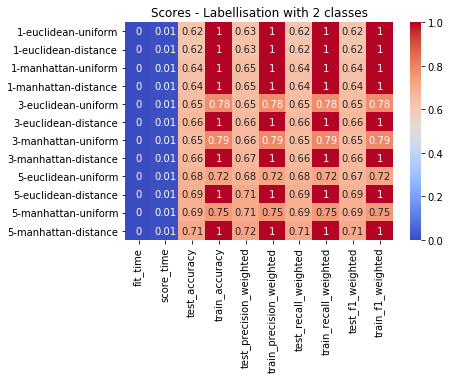

In [14]:
full_scores = pds.DataFrame(full_scores)
plt.title('Scores - Labellisation with 2 classes')
sns.heatmap(full_scores.T.round(2),annot=True,cmap='coolwarm')

Le meilleur résultat retenu est celui avec 5-manhattan-distance modèle, qui a *test_accuracy = 0.71*. Il a réussi à prédire l'appartenance de quasiment 3/4 des pays. On remarque aussi que tous les algorithmes utilisant le poids *distance* ont une précision absolue sur le *training* dataset.

### Decision Tree and SVM

La k-NN n'est pas la seule méthode qu'on peut utiliser pour la classification. Parmi les autres, on trouve *Decision Tree* qui utilise une arborescence et *SVM (Support Vector Machine)* qui cherche une section (droite, plan) qui sépare optimalement des données en 2 groupes.

On compare la méthode *k*-NN (utilisée avec les paramètres optimaux déterminés précedemment) avec un *Decision Tree* et *SVM* par défaut. On affiche ainsi la précision des 3 méthodes. 

In [15]:
cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

knn = KNeighborsClassifier(n_neighbors=5, weights='distance', \
                           metric='manhattan')
scores_knn = cross_validate(knn, dfz, labels, scoring=scoring,cv=cv, \
                            return_train_score=True)
scores_knn = pds.DataFrame(scores_knn).mean()

dtc = DecisionTreeClassifier()
scores_dtc = cross_validate(dtc, dfz, labels, scoring=scoring,cv=cv, \
                            return_train_score=True)
scores_dtc = pds.DataFrame(scores_dtc).mean()

svm = SVC(kernel='linear')
scores_svm_l = cross_validate(svm, dfz, labels, scoring=scoring,cv=cv, \
                              return_train_score=True)
scores_svm_l = pds.DataFrame(scores_svm_l).mean()

svm2 = SVC(kernel='rbf')
scores_svm_rbf = cross_validate(svm2, dfz, labels, scoring=scoring,cv=cv, \
                                return_train_score=True)
scores_svm_rbf = pds.DataFrame(scores_svm_rbf).mean()

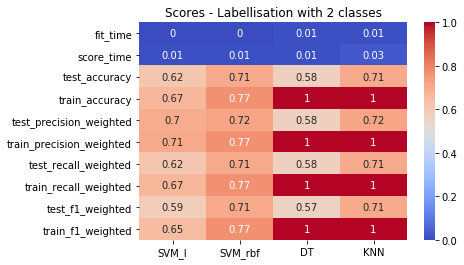

In [16]:
full_scores = pds.DataFrame({"SVM_l": scores_svm_l, "SVM_rbf":scores_svm_rbf, \
                             "DT":scores_dtc, "KNN":scores_knn})
plt.title('Scores - Labellisation with 2 classes')
sns.heatmap(full_scores.T.round(2).T,annot=True,cmap='coolwarm')

Les nouvelles méthodes s'avèrent plutôt équivalentes à la k-NN. La SVM donne un test_accuracy égal à 0.71 avec le kernel rbf. La précision est légèrement supérieure à celle de k-NN. Avec le kernel linear, on obtient test_accuracy égal à 0.6, ce qui est moins bien. Avec la méthode SVM, la précision de training dataset n'est pas égale à 1 comme c'est le cas pour les autres méthodes.  

La méthode Decision Tree montre un test_accuracy égal 0.58, cette dernière est donc légèrement moins précise que les autres méthodes.

### Visualisations

On peut utiliser une Clustermap pour représenter le dataset.

Text(0.5,0.98,'Clustermap')

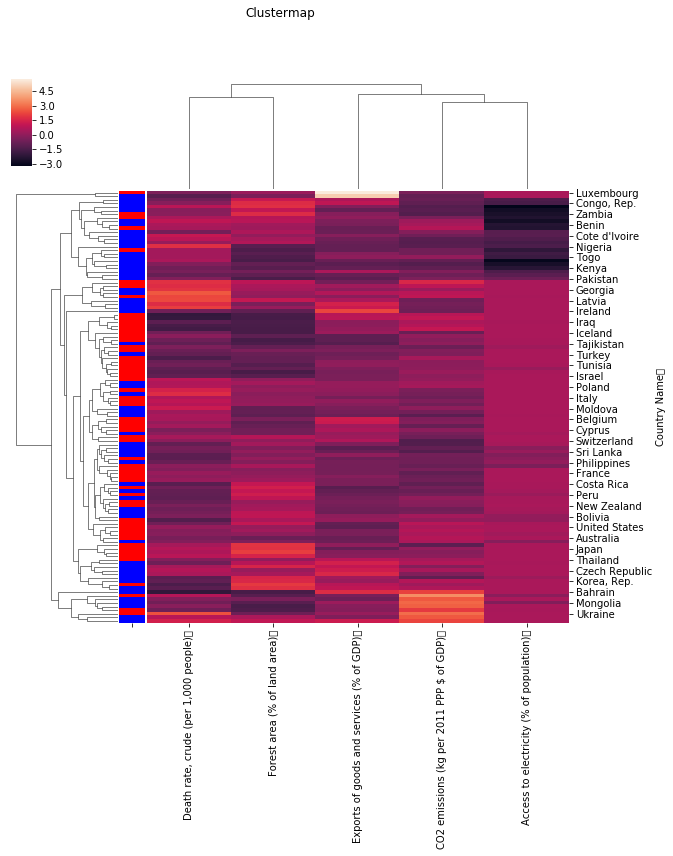

In [17]:
y = pds.Series(labels)
y.index = dfz.index
lut = dict(zip(y.unique(), "rb"))
row_colors = y.map(lut)
g = sns.clustermap(dfz, row_colors=row_colors)
g.fig.suptitle('Clustermap') 

Cette visualition nous permet de réperer visuellement les différences entre les pays.

In [18]:
#from sklearn.tree import plot_tree
#fig = plt.figure(figsize=(15, 10))
#plot_tree(dtc,filled=True, feature_names=dfz.columns)

La commande *plot_tree* nous permet de répresenter l'arbre de décision de la méthode *DT* et regarder à l'intérieur du résultat d'algorhitme.

### N-classes 

On utilise le clustering pour diviser le PIB en classes. Nous utiliserons les valeurs de la sse et du coefficient silhouette pour les différents nombres de clusters simulés, ce qui nous aidera à choisir le nombre de clusters idéal. On choisit l'algorithme des *K*-means pour séparer notre jeu de données en clusters. 

In [19]:
sse = {}
silhouette = {}
for k in range(2,12):
    km = KMeans(k).fit(dfz)
    sse[k] = km.inertia_
    clusters = km.predict(dfz)
    silhouette[k] = metrics.silhouette_score(dfz,clusters)
sse = pds.Series(sse)
silhouette = pds.Series(silhouette)

Text(0.5,0,'k')

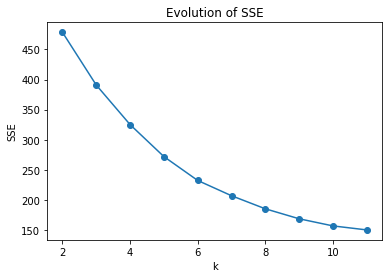

In [20]:
plt.plot(range(2,12),sse,"o-")
plt.title('Evolution of SSE')
plt.ylabel("SSE")
plt.xlabel('k')

D'après la sse, le nombre de clusters a privilégier serait 6. Mais ce nombre de clusters est assez élevé. Voyons ce que nous pouvons dire d'après le coefficient silhouette :

Text(0.5,0,'k')

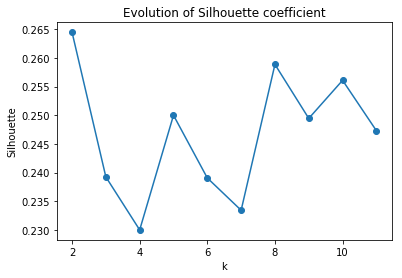

In [21]:
plt.plot(range(2,12),silhouette,"o-")
plt.title('Evolution of Silhouette coefficient')
plt.ylabel("Silhouette")
plt.xlabel('k')

D'après le coefficient silhouette, le choix idéal de clusters serait 2 ou 8. En effet, c'est pour ces valeurs que les points sont les mieux classés (pour chaque point, la distance aux points du même cluster est plus faible que celle aux points des autres clusters). 

Il est donc judicieux de prendre un nombre de clusters égal à 5. Cette valeur semble être un bon compris entre nos deux critères utilisés. 

In [22]:
k = 5
clusters = KMeans(k).fit_predict(dfz)

knn = KNeighborsClassifier(n_neighbors=5, weights='distance', \
                           metric='manhattan')
scores_knn = cross_validate(knn, dfz, clusters, scoring=scoring,cv=cv, \
                            return_train_score=True)
scores_knn = pds.DataFrame(scores_knn).mean()

dt = DecisionTreeClassifier().fit(dfz,clusters)
scores_dtc = cross_validate(dt, dfz, clusters, scoring=scoring,cv=cv, \
                            return_train_score=True)
scores_dtc = pds.DataFrame(scores_dtc).mean()

svm2 = SVC(kernel='rbf')
scores_svm_rbf = cross_validate(svm2, dfz, clusters, scoring=scoring,cv=cv, \
                                return_train_score=True)
scores_svm_rbf = pds.DataFrame(scores_svm_rbf).mean()

n_full_scores = {}
n_full_scores['K-NN'] = scores_knn
n_full_scores['DT'] = scores_dtc
n_full_scores['svm-rbf'] = scores_svm_rbf


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups

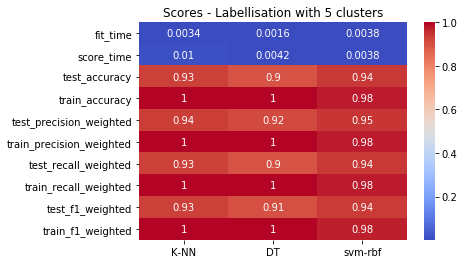

In [23]:
n_full_scores = pds.DataFrame(n_full_scores)
plt.title('Scores - Labellisation with 5 clusters')
sns.heatmap(n_full_scores,annot=True,cmap='coolwarm')

Les 3 méthodes ont des bien meilleurs résultats qu'au cas avec 2 classes. La *KNN* et la *SVM* ont un  *test_accuracy* très précis (autour de * 0.94*), les prédictions sont donc quasiment idéntiques aux clusters. *Decision Tree* a une qualité inférieure avec *test_accuracy = 0.9*.

Néanmoins, la labellisation a été faite avec un outil de clustering K-means. Il se peut alors que cet outil ait des similarités importantes avec le Decision Tree qui nous augmente significativement le score. Autrement dit, la labellisation n'est peut-être pas indépendante de la classification.

## Outliers

On utilise une méthode non-supervisée DB-scan pour essayer de déterminer des outliers possibles que l'on pourrait enlever de notre dataset pour améliorer les modèles.

In [24]:
dbscan = DBSCAN(eps=2)
outliers = dbscan.fit_predict(dfz)
outliers = outliers == -1
df[outliers]

,CO2 emissions (kg per 2011 PPP $ of GDP),Access to electricity (% of population),Exports of goods and services (% of GDP),"Death rate, crude (per 1,000 people)",Forest area (% of land area)
Country Name,,,,,
Luxembourg,0.188005,100.0,212.607099,6.9,35.679011
Singapore,0.125740,100.0,191.953536,4.7,23.060649
Ukraine,0.641222,100.0,48.592962,14.7,16.632775


On enlève ces 3 pays de notre dataset et on refait nos 3 modèles de classification avec 5 clusters qui se sont avérés les plus intéressants : 
- *KNN* avec 5 voisins, *distance* et *manhattan*
- *Decision Tree*
- *SVM* avec *RBF* kernel


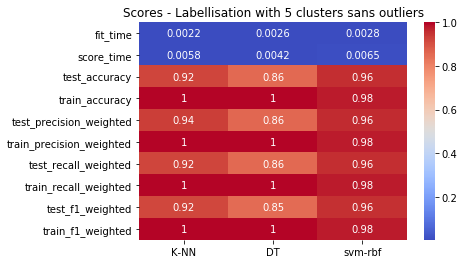

In [25]:
dfz.drop(['Luxembourg', 'Singapore', 'Ukraine'])


k = 4
clusters = KMeans(k).fit_predict(dfz)

knn = KNeighborsClassifier(n_neighbors=5, weights='distance', \
                           metric='manhattan')
scores_knn = cross_validate(knn, dfz, clusters, scoring=scoring,cv=cv, \
                            return_train_score=True)
scores_knn = pds.DataFrame(scores_knn).mean()

dt = DecisionTreeClassifier().fit(dfz,clusters)
scores_dtc = cross_validate(dt, dfz, clusters, scoring=scoring,cv=cv, \
                            return_train_score=True)
scores_dtc = pds.DataFrame(scores_dtc).mean()

svm2 = SVC(kernel='rbf')
scores_svm_rbf = cross_validate(svm2, dfz, clusters, scoring=scoring,cv=cv, \
                                return_train_score=True)
scores_svm_rbf = pds.DataFrame(scores_svm_rbf).mean()

n_full_scores = {}
n_full_scores['K-NN'] = scores_knn
n_full_scores["DT"] = scores_dtc
n_full_scores['svm-rbf'] = scores_svm_rbf

n_full_scores = pds.DataFrame(n_full_scores)
plt.title('Scores - Labellisation with 5 clusters sans outliers')
sns.heatmap(n_full_scores,annot=True,cmap='coolwarm')

Les valeurs obtenues dans ce tableau semblent similaires à celles d'avant. Le retrait ne change pas particulièrement la prédiction des labels.

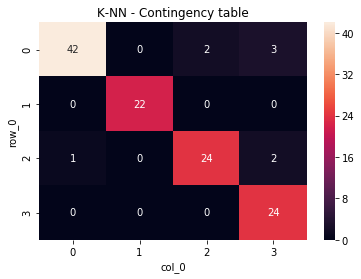

In [26]:
knn.fit(dfz[:40], clusters[:40])
res = knn.predict(dfz)
crosstab = pds.crosstab(res,np.asarray(clusters))
plt.title('K-NN - Contingency table')
sns.heatmap(crosstab, annot=True)

La table de contingence nous permet de comparer les **classes** obtenues avec les méthodes de classification avec les **clusters** de K-means.

**K-NN**

On voit qu'un cluster a 5 pays qui se sont dispersés dans d'autres classes et une classe correspond parfaitement à son cluster. Quelques d'autres erreurs sont présentes, mais en général on voit la précision de cette méthode.

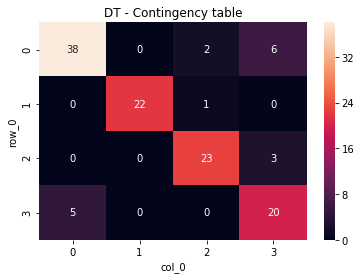

In [27]:
dt.fit(dfz[:40], clusters[:40])
res = dt.predict(dfz)
crosstab = pds.crosstab(res,np.asarray(clusters))
plt.title('DT - Contingency table')
sns.heatmap(crosstab, annot=True)

**Decision Tree**

Decision Tree a le pire score sur les 3 méthodes - on observe plus de pays qui s'écartent de son cluster. Un cluster est particulièrement mal évalué avec 9 individus dans les classes différentes. Un cluster est de nouveau complètement identifié.

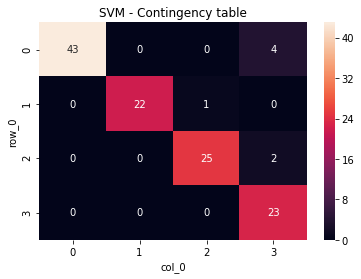

In [28]:
svm2.fit(dfz[:40], clusters[:40])
res = svm2.predict(dfz)
crosstab = pds.crosstab(res,np.asarray(clusters))
plt.title('SVM - Contingency table')
sns.heatmap(crosstab, annot=True)

**SVM**

On observe peu d'erreurs - 2 clusters complètement identifié et un avec une erreur. Le dernier cluster possède de nouveau 6 pays mal identifiés.

On voit qu'un cluster pose des problèmes à toutes les 3 méthodes et un autre, au contraire, a été parfaitement évalué. Néanmoins, les pays sont souvent très proches économiquement et écologiquement à ses voisins et donc on ne peut pas empêcher une intrusion d'erreur. Les résultats qu'on obtient sont quand-même plutôt satisfaisants.

On regardera les classes concrètement, on étudiera les classes créées par SVM ainsi que leur croissance de PIB moyen.

In [29]:
c1  = []; c2  = []; c3  = []; c4  = []
lab = svm2.predict(dfz)
gdp = [[] for x in range(120)]
PIB.drop(['Luxembourg', 'Singapore', 'Ukraine'])
for i in range(len(lab)) :
    if lab[i] == 0 :
        c1.append(dfz.index[i])
        gdp[0].append(PIB.iloc[i])
    elif lab[i] == 1 :
        c2.append(dfz.index[i])
        gdp[1].append(PIB.iloc[i])
    elif lab[i] == 2 :
        c3.append(dfz.index[i])
        gdp[2].append(PIB.iloc[i])
    else :
        c4.append(dfz.index[i])
        gdp[3].append(PIB.iloc[i])
print(PIB.describe())
print(c1, np.mean(gdp[0]))
print(c2, np.mean(gdp[1]))
print(c3, np.mean(gdp[2]))
print(c4, np.mean(gdp[3]))

count    120.000000
mean       2.172657
std        2.421433
min       -4.731050
25%        1.025368
50%        2.167883
75%        3.563021
max        7.766030
Name: GDP per capita growth (annual %)\t, dtype: float64
['Albania', 'Austria', 'Bolivia', 'Brazil', 'Brunei Darussalam', 'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Finland', 'France', 'Ghana', 'Greece', 'Guatemala', 'Honduras', 'Indonesia', 'Italy', 'Jamaica', 'Japan', 'Korea, Rep.', 'Malaysia', 'Mauritius', 'Mexico', 'Montenegro', 'Nepal', 'New Zealand', 'Nicaragua', 'North Macedonia', 'Norway', 'Panama', 'Paraguay', 'Peru', 'Philippines', 'Portugal', 'Slovenia', 'Spain', 'Sri Lanka', 'Sweden', 'Switzerland', 'United Kingdom', 'United States', 'Uruguay', 'Venezuela, RB', 'Vietnam'] 1.924151607101343
['Angola', 'Bangladesh', 'Benin', 'Botswana', 'Cambodia', 'Cameroon', 'Congo, Dem. Rep.', 'Congo, Rep.', "Cote d'Ivoire", 'Ethiopia', 'Haiti', 'Kenya', 'Mozambique', 'Myanmar', 'Na

On remarque immédiatement la présence d'une classe composée des pays en développement qui se trouvent en Afrique et en Asie (Angola, Bangladesh, ... , Zimbabwe). Ils ont une croissance de PIB très important qui correspond à leur stade de développement *PIB = 3.75*, sachant que le 3e quartile est à 3.56. Nos facteurs économiques, écologiques et sociétaux réussisnt à démasquer ces pays.

L'intérpretation des autres classes n'est pas si évidente. Contrairement au cas précedant, une classe possède une croissance de PIB moyen très bas (1.11), proche au premier quartile (1.02). Cette classe comporte des pays de tous les continents, avec une majorité importante venant du Proche-Orient. 

Une autre classe contient davantage des pays de l'Europe de l'Est. Une croissance élevée de PIB indique que la phase de développement est encore (en partie) présente chez ces pays ce qui peut être intérpreté comme une expansion économique après la chute du rideau de fer.

La dernière classe comporte le plus grand nombre de pays, elle est donc assez générale avec une croissance de PIB moyenne. 

# Conclusion

On a utilisé plusieurs outils de Machine Learning pour classifier les pays du monde d'après leur PIB. Le PIB est un facteur qui caractèrise assez bien le pays et il est bien compréhensible. Il peut dépendre de beaucoup d'autres variables - ici, on essaie de le classifier grâce aux variables comme émissions de CO<sub>2</sub>, l'accès à l'éléctricité, le taux de mortalité et le pourcentage de surface boisée et d'autres. On a exploité les méthode *k-nearest neighbours, Decision Tree* et *Support Vecteur Machine* en faisant varier les paramètres pour avoir une classification optimale, tout cela avec 2 et 5 classes de PIB. En enlevant les outliers, on a réussi à approcher la précision de nos classifications vers 1 et donc créer des modèles qui arrivent à bien distinguer la puissance économique d'un pays grâce à d'autres variables.